# ArangoDB 🥑 + LangChain 🦜🔗

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/Langchain.ipynb)

Large language models (LLMs) ~are emerging~ have emerged as a transformative technology, enabling developers to build applications that they previously could not. However, using these LLMs in isolation is often insufficient for creating a truly powerful app - the real power comes when you can combine them with other sources of computation or knowledge.

[LangChain](https://www.langchain.com/) is a framework for developing applications powered by language models. It enables applications that are:
- Data-aware: connect a language model to other sources of data
- Agentic: allow a language model to interact with its environment

This notebook will leverage LLMs to provide a natural language interface to querying ArangoDB.

**Please note**: We'll be using the LangChain `ChatOpenAI` wrapper, which requires you to have a **paid** [OpenAI API Key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). However, other Chat Models are available as well: https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models

In [1]:
%%capture

# Set your OpenAI API Key
# https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key

!pip install langchain==0.0.314
!pip install openai==0.28.1

import os

os.environ["OPENAI_API_KEY"] = "sk-..."


## LangChain 101

There are six basic components of Langchain:
- **Models**: the library of LLMs to choose from
- **Prompts**: text that guides the LLM to generate the desired output
- **Chains**: sequences of instructions the LangChain framework executes to perform a task
- **Memory**: a method of storing data for the LLM to access later
- **Agents & Tools**: the essential components to perform specific tasks based on user context
- **Indexes, Vectorstores, & Retrievers**: the essential components to building an app on your specific data

In [2]:
# 1. Install dependencies

%%capture
!pip install wikipedia
!pip install sentence_transformers
!pip install faiss-cpu
!pip install chromadb
!pip install tiktoken

In [3]:
# 2. Basic Prompting

from langchain.llms import OpenAI

model = OpenAI(temperature=0)

print(model("What is ArangoDB?"))



ArangoDB is an open source, multi-model NoSQL database that combines the power of graphs, documents, and key-value pairs. It is designed to provide developers with an easy-to-use, high-performance database for modern applications. ArangoDB is written in C++ and provides a flexible data model for documents, graphs, and key-value pairs. It also offers a powerful query language, AQL, for querying and manipulating data. ArangoDB is highly scalable and can be deployed on-premise, in the cloud, or as a service.


In [4]:
# 3. Prompting with Templates

from langchain import PromptTemplate

template = """
  Question: {question}
  Use sarcasm!
"""

prompt = PromptTemplate(template=template, input_variables=["question"])

print(model(prompt.format(question="What is ArangoDB?")))


Answer: ArangoDB is the best database ever invented - NOT!


In [5]:
# 4. Prompting with Chains

from langchain import LLMChain

chain = LLMChain(prompt=prompt, llm=model)

question = "What is ArangoDB?"

print(chain.run(question))


Answer: ArangoDB is the best database ever invented - not!


In [6]:
# 5. Prompting with Memory

from langchain import OpenAI, ConversationChain

model = OpenAI(temperature=0)

conversation = ConversationChain(llm=model, verbose=True)

conversation.predict(input="How old is C++?")
conversation.predict(input="Sorry I meant ArangoDB")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: How old is C++?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: How old is C++?
AI:  C++ is a programming language that was first released in 1985, so it is 35 years old.
Human: Sorry I meant ArangoDB
AI:

> Finished chain.


' ArangoDB is a multi-model NoSQL database system that was first released in 2013, so it is 7 years old.'

In [7]:
# 6. Prompting via Agent

from langchain.agents import load_tools
from langchain.agents import initialize_agent

model = OpenAI(temperature=0)

tools = load_tools(["wikipedia", "llm-math"], llm=model)

agent = initialize_agent(tools, model, agent="zero-shot-react-description", verbose=True)

agent.run("What is 2 + 2")
agent.run("How old is ArangoDB?")



> Entering new AgentExecutor chain...
 I need to calculate this
Action: Calculator
Action Input: 2 + 2
Observation: Answer: 4
Thought: I now know the final answer
Final Answer: 2 + 2 = 4

> Finished chain.


'2 + 2 = 4'

In [8]:
# 7. Prompting with Indexes (1): Data Load

# Using ChromaDB & LangChain to perform question answering over documents.

from langchain.document_loaders import TextLoader
import requests

# Fetch some sample data
url = "https://raw.githubusercontent.com/hwchase17/chroma-langchain/master/state_of_the_union.txt"
res = requests.get(url)

with open("state_of_the_union.txt", "w") as f:
  f.write(res.text)

# Load documents
loader = TextLoader('state_of_the_union.txt')
documents = loader.load()

len(documents)

1

In [9]:
# 7. Prompting with Indexes (2): Text Splitting

# Next: splitting documents into small chunks.
# This is so we can find the most relevant chunks
# for a query and pass only those into the LLM.

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

len(texts)

42

In [10]:
# 7. Prompting with Indexes (3): Initialize PeristedChromaDB

# Create embeddings for each chunk and insert
# into the Chroma vector database.
# The persist_directory argument tells ChromaDB
# where to store the database when it's persisted.

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Embed and store the texts
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=texts, embedding=embedding)

vectordb

In [11]:
# 7. Prompting with Indexes (5): Create the chain
from langchain.chains.retrieval_qa.base import VectorDBQA

chain = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=vectordb)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:251: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [12]:
# 7. Prompting with Indexes (6): Asking questions

print(chain.run("TL;DR the president's message for me"))
print('-'*100)
print(chain.run("What did the president say specifically about Russian oligarchs?"))
print('-'*100)
print(chain.run("How much did the President say the economy grew last year?"))

 The president is optimistic about America's future and believes that together we can protect freedom and liberty, strengthen democracy, and have the capacity to do big things like beat the opioid epidemic.
----------------------------------------------------------------------------------------------------
 The president said that the U.S. Department of Justice is assembling a dedicated task force to go after the crimes of Russian oligarchs and that they will join their European allies to find and seize their yachts, luxury apartments, and private jets.
----------------------------------------------------------------------------------------------------
 The President said that the economy grew at a rate of 5.7% last year.


- Question-Answering in LangChain: https://python.langchain.com/docs/use_cases/question_answering/
- Integrations in LangChain: https://python.langchain.com/docs/integrations/providers

---
## Setup

### Preliminaries

In [13]:
%%capture

# 1: Install the dependencies

!pip install python-arango # The ArangoDB Python Driver
!pip install adb-cloud-connector # The ArangoDB Cloud Instance provisioner
!pip install arango-datasets # Datasets package

In [14]:
# 2. Helper Function Definitions

import json

def pprint(data):
  print(json.dumps(data, indent=4))

def query(db, aql):
  pprint(list(db.aql.execute(aql)))

In [15]:
# 3. Provisioning ArangoDB

from adb_cloud_connector import get_temp_credentials

credentials = get_temp_credentials()

pprint(credentials)

Log: requesting new credentials...
Succcess: new credentials acquired
{
    "dbName": "TUT2cqh6w6r5hqtf9h8ckrfaf",
    "username": "TUTee8jnivdjkqld7dzszvjme",
    "password": "TUT89hkelkiyc8gvw0ja38dtc",
    "hostname": "tutorials.arangodb.cloud",
    "port": 8529,
    "url": "https://tutorials.arangodb.cloud:8529"
}


In [16]:
# 4. Connecting to ArangoDB

from arango import ArangoClient

client = ArangoClient(credentials["url"], request_timeout=None)

db = client.db(
    name=credentials["dbName"],
    username=credentials["username"],
    password=credentials["password"],
    verify=True
)

db

<StandardDatabase TUT2cqh6w6r5hqtf9h8ckrfaf>

### Loading Datasets

#### Game Of Thrones

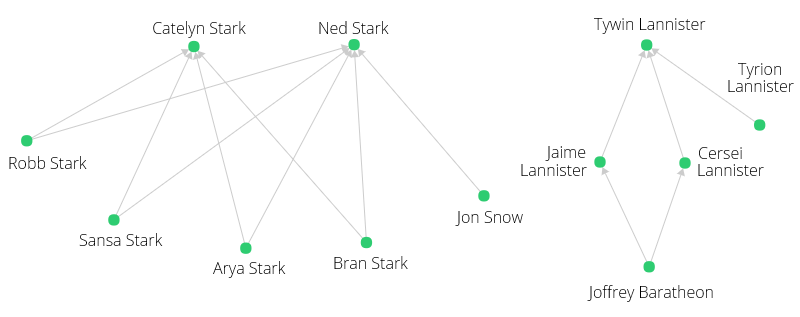

In [17]:
# (13 nodes, 15 edges)

# This dataset represents the parent-child
# relationships of certain characters from the GoT universe

if db.has_graph("GameOfThrones"):
    db.delete_graph("GameOfThrones", drop_collections=True)


edge_definitions=[
    {
        "edge_collection": "ChildOf",
        "from_vertex_collections": ["Characters"],
        "to_vertex_collections": ["Characters"],
    }
]

documents = [
    # Starks (8)
    {"_key": "RickardStark", "name": "Rickard", "surname": "Stark", "alive": False, "age": 60, "gender": "male"},
    {"_key": "LyarraStark", "name": "Lyarra", "surname": "Stark", "alive": False, "age": 60, "gender": "female"},
    {"_key": "NedStark", "name": "Ned", "surname": "Stark", "alive": True, "age": 41, "gender": "male"},
    {"_key": "CatelynStark", "name": "Catelyn", "surname": "Stark", "alive": False, "age": 40, "gender": "female"},
    {"_key": "AryaStark", "name": "Arya", "surname": "Stark", "alive": True, "age": 11, "gender": "female"},
    {"_key": "BranStark", "name": "Bran", "surname": "Stark", "alive": True, "age": 10, "gender": "male"},
    { "_key": "RobbStark", "name": "Robb", "surname": "Stark", "alive": False, "age": 16, "gender": "male"},
    { "_key": "SansaStark", "name": "Sansa", "surname": "Stark", "alive": True, "age": 13, "gender": "female"},

    # Lannisters (4)
    { "_key": "TywinLannister", "name": "Tywin", "surname": "Lannister", "alive": False, "age": 67, "gender": "male" },
    { "_key": "JaimeLannister", "name": "Jaime", "surname": "Lannister", "alive": True, "age": 36, "gender": "male" },
    { "_key": "CerseiLannister", "name": "Cersei", "surname": "Lannister", "alive": True, "age": 36, "gender": "female" },
    { "_key": "TyrionLannister", "name": "Tyrion", "surname": "Lannister", "alive": True, "age": 32, "gender": "male" },

    # Baratheons (1)
    { "_key": "JoffreyBaratheon", "name": "Joffrey", "surname": "Baratheon", "alive": False, "age": 19, "gender": "male"},
]

edges = [
    {"_to": "Characters/NedStark", "_from": "Characters/BranStark"},
    {"_to": "Characters/NedStark", "_from": "Characters/RobbStark" },
    {"_to": "Characters/NedStark", "_from": "Characters/SansaStark" },
    {"_to": "Characters/NedStark", "_from": "Characters/AryaStark" },
    {"_to": "Characters/CatelynStark", "_from": "Characters/AryaStark"},
    {"_to": "Characters/CatelynStark", "_from": "Characters/BranStark"},
    {"_to": "Characters/CatelynStark", "_from": "Characters/RobbStark" },
    {"_to": "Characters/CatelynStark", "_from": "Characters/SansaStark" },
    {"_to": "Characters/RickardStark", "_from": "Characters/NedStark"},
    {"_to": "Characters/LyarraStark", "_from": "Characters/NedStark"},

    {"_to": "Characters/TywinLannister", "_from": "Characters/JaimeLannister" },
    {"_to": "Characters/TywinLannister", "_from": "Characters/CerseiLannister" },
    {"_to": "Characters/TywinLannister", "_from": "Characters/TyrionLannister" },
    {"_to": "Characters/CerseiLannister", "_from": "Characters/JoffreyBaratheon" },
    {"_to": "Characters/JaimeLannister", "_from": "Characters/JoffreyBaratheon" }
]

db.delete_graph("GameOfThrones", ignore_missing=True, drop_collections=True)
db.create_graph("GameOfThrones", edge_definitions)

db.collection("Characters").import_bulk(documents)
db.collection("ChildOf").import_bulk(edges)

{'error': False,
 'created': 15,
 'errors': 0,
 'empty': 0,
 'updated': 0,
 'ignored': 0,
 'details': []}

#### GDELT Project (Open Intelligence)

> GDELT monitors the world's news media from nearly every corner of every country
in print, broadcast, and web formats, in over 100 languages,
every moment of every day. [...] Put simply, the GDELT Project is a realtime open data global graph over human society as seen through the eyes of the world's news media, reaching deeply into local events, reaction, discourse, and emotions of the most remote corners of the world in near-realtime and making all of this available as an open data firehose to enable research over human society.


In [18]:
# (~70k nodes, ~400 edges)
# https://www.gdeltproject.org/

from arango_datasets.datasets import Datasets

Datasets(db).load("OPEN_INTELLIGENCE")

edge_definitions = [
    {
        "edge_collection": "hasLocation",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Location"],
    },
    {
        "edge_collection": "hasSource",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Source"],
    },
    {
        "edge_collection": "inCountry",
        "from_vertex_collections": ["Location"],
        "to_vertex_collections": ["Country"],
    },
    {
        "edge_collection": "inRegion",
        "from_vertex_collections": ["Country"],
        "to_vertex_collections": ["Region"],
    },
    {
        "edge_collection": "eventActor",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Actor"],
    },
    {
        "edge_collection": "subClass",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Class"],
    },
    {
        "edge_collection": "type",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Class"],
    },
]

db.create_graph("OpenIntelligence", edge_definitions=edge_definitions)

Output()

Output()

Downloaded file for: eventActor, now importing... 


Finished loading current file for collection: eventActor


Output()

Output()

Downloaded file for: hasLocation, now importing... 


Finished loading current file for collection: hasLocation


Output()

Output()

Downloaded file for: hasSource, now importing... 


Finished loading current file for collection: hasSource


Output()

Output()

Downloaded file for: inCountry, now importing... 


Finished loading current file for collection: inCountry


Output()

Output()

Downloaded file for: inRegion, now importing... 


Finished loading current file for collection: inRegion


Output()

Output()

Downloaded file for: subClass, now importing... 


Finished loading current file for collection: subClass


Output()

Output()

Downloaded file for: type, now importing... 


Finished loading current file for collection: type


Output()

Output()

Downloaded file for: Actor, now importing... 


Finished loading current file for collection: Actor


Output()

Output()

Downloaded file for: Class, now importing... 


Finished loading current file for collection: Class


Output()

Output()

Downloaded file for: Country, now importing... 


Finished loading current file for collection: Country


Output()

Output()

Downloaded file for: Event, now importing... 


Finished loading current file for collection: Event


Output()

Output()

Downloaded file for: Location, now importing... 


Finished loading current file for collection: Location


Output()

Output()

Downloaded file for: Region, now importing... 


Finished loading current file for collection: Region


Output()

Output()

Downloaded file for: Source, now importing... 


Finished loading current file for collection: Source


<Graph OpenIntelligence>

### Configuring LangChain

In [19]:
# 1: Instantiate the ArangoDB-LangChain Graph wrapper

from langchain.graphs import ArangoGraph

graph = ArangoGraph(db)

pprint(graph.schema)

{
    "Graph Schema": [
        {
            "graph_name": "GameOfThrones",
            "edge_definitions": [
                {
                    "edge_collection": "ChildOf",
                    "from_vertex_collections": [
                        "Characters"
                    ],
                    "to_vertex_collections": [
                        "Characters"
                    ]
                }
            ]
        },
        {
            "graph_name": "OpenIntelligence",
            "edge_definitions": [
                {
                    "edge_collection": "eventActor",
                    "from_vertex_collections": [
                        "Event"
                    ],
                    "to_vertex_collections": [
                        "Actor"
                    ]
                },
                {
                    "edge_collection": "hasLocation",
                    "from_vertex_collections": [
                        "Event"
                    ],
  

In [20]:
# 2: Instantiate the OpenAI Chat model
# Note that other models can be used as well
# Ref: https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models

from langchain.chat_models import ChatOpenAI

model = ChatOpenAI(temperature=0, model_name='gpt-4')

In [21]:
# 3: Instantiate the LangChain Question-Answering Chain with
# our **model** and **graph**

from langchain.chains import ArangoGraphQAChain

chain = ArangoGraphQAChain.from_llm(model, graph=graph, verbose=True)

---
## Prompting

#### Game Of Thrones

In [22]:
chain.run("Who are the 2 youngest characters?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR c IN Characters
SORT c.age ASC
LIMIT 2
RETURN c

AQL Result:
[{'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_g4WPppS--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}]

> Finished chain.


'The two youngest characters are Bran Stark, who is 10 years old, and Arya Stark, who is 11 years old.'

In [23]:
chain.run("How are Bran Stark and Arya Stark related?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..10 ANY 'Characters/BranStark' ChildOf
  FILTER v._key == 'AryaStark'
  RETURN v

AQL Result:
[{'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'A

'Bran Stark and Arya Stark are related as siblings. Both characters belong to the Stark family in the Game of Thrones series. Arya Stark is a female character who is currently alive and 11 years old.'

In [24]:
chain.run("Who are Bran Stark’s grandparents?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 OUTBOUND 'Characters/BranStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'LyarraStark', '_id': 'Characters/LyarraStark', '_rev': '_g4WPppS--_', 'name': 'Lyarra', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'female'}, {'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_g4WPppS---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}]



> Finished chain.


"Bran Stark's grandparents are Lyarra Stark and Rickard Stark."

In [25]:
chain.run("Fetch me the character count for each family")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR character IN Characters
    FILTER character.surname != null
    COLLECT family = character.surname WITH COUNT INTO count
    RETURN { "family": family, "count": count }

AQL Result:
[{'family': 'Baratheon', 'count': 1}, {'family': 'Lannister', 'count': 4}, {'family': 'Stark', 'count': 8}]

> Finished chain.


'The count of characters for each family in the database is as follows: There is 1 character from the Baratheon family, 4 characters from the Lannister family, and 8 characters from the Stark family.'

In [26]:
chain.run("What is the age difference between Rickard Stark and Arya Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
FOR rickard IN Characters
    FILTER rickard._key == 'RickardStark'
FOR arya IN Characters
    FILTER arya._key == 'AryaStark'
RETURN ABS(rickard.age - arya.age)

AQL Result:
[49]



> Finished chain.


'The age difference between Rickard Stark and Arya Stark is 49 years.'

In [27]:
chain.run("Wie alt ist Rickard Stark?") # (German: "How old is Rickard Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character._key == 'RickardStark'
    RETURN character.age

AQL Result:
[60]



> Finished chain.


'Rickard Stark ist 60 Jahre alt.'

In [28]:
chain.run("What is the average age within the Stark family?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character.surname == 'Stark'
    COLLECT AGGREGATE avgAge = AVG(character.age)
    RETURN avgAge

AQL Result:
[31.375]



> Finished chain.


'The average age within the Stark family is approximately 31.4 years.'

In [29]:
chain.run("Does Bran Stark have a dead parent?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 OUTBOUND 'Characters/BranStark' ChildOf
FILTER v.alive == false
RETURN v

AQL Result:
[{'_key': 'CatelynStark', '_id': 'Characters/CatelynStark', '_rev': '_g4WPppS--B', 'name': 'Catelyn', 'surname': 'Stark', 'alive': False, 'age': 40, 'gender': 'female'}]



> Finished chain.


'Yes, Bran Stark has a dead parent. His mother, Catelyn Stark, is deceased.'

In [30]:
chain.run("Who are Catelyn Stark's children?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 OUTBOUND 'Characters/CatelynStark' ChildOf
RETURN v

AQL Result:
[]

> Finished chain.


'Based on the data in the database, Catelyn Stark does not have any children recorded.'

In [31]:
chain.run("Add Jon Snow, 31, a male character")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
INSERT { "_key": "JonSnow", "name": "Jon", "surname": "Snow", "alive": true, "age": 31, "gender": "male" } INTO Characters

AQL Result:
[]



> Finished chain.


'Summary:\nJon Snow, a 31-year-old male character, has been successfully added to the database.'

In [32]:
chain.run("Create a ChildOf edge from Jon Snow to Ned Stark")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
INSERT {
  _from: "Characters/JonSnow",
  _to: "Characters/NedStark"
} INTO ChildOf

AQL Result:
[]



> Finished chain.


'A relationship has been established in the database indicating that Jon Snow is a child of Ned Stark.'

In [33]:
chain.run("Who is related to Ned Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 ANY 'Characters/NedStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'JonSnow', '_id': 'Characters/JonSnow', '_rev': '_g4WcAvO---', 'name': 'Jon', 'surname': 'Snow', 'alive': True, 'age': 31, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'SansaStark', '_id': 'Characters/SansaStark', '_rev': '_g4WPppS--F', 'name': 'Sansa', 'surname': 'Stark', 'alive': True, 'age': 13, 'gender': 'female'}, {'_key': 'RobbStark', '_id': 'Characters/RobbStark', '_rev': '_g4WPppS--E', 'name': 'Robb', 'surname': 'Stark', 'alive': False, 'age': 16, 'gender': 'male'}, {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_g4WPppS--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}, {'_key': 'LyarraStark', '_id': 'Characters/LyarraStark', '_rev': '_g4WPppS--_', 'name': 'Lyarra', '


> Finished chain.


"Ned Stark is related to several characters. His children are Jon Snow, Arya Stark, Sansa Stark, Robb Stark, and Bran Stark. Jon Snow is 31 years old and alive, Arya Stark is 11 years old and alive, Sansa Stark is 13 years old and alive, Robb Stark was 16 years old and is deceased, and Bran Stark is 10 years old and alive. Ned Stark's parents are Lyarra Stark and Rickard Stark, both of whom are deceased and were 60 years old."

In [34]:
chain.run("What can you tell me about the characters?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
FOR character IN Characters
RETURN character

AQL Result:
[{'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_g4WPppS---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}, {'_key': 'LyarraStark', '_id': 'Characters/LyarraStark', '_rev': '_g4WPppS--_', 'name': 'Lyarra', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'female'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'CatelynStark', '_id': 'Characters/CatelynStark', '_rev': '_g4WPppS--B', 'name': 'Catelyn', 'surname': 'Stark', 'alive': False, 'age': 40, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_g4WPppS--D', 'name': 'Bran', 'surname': 'Stark',


> Finished chain.


'The database contains information about several characters. Here are some of them:\n\n1. Rickard Stark: He is a male character who is not alive. He was 60 years old.\n2. Lyarra Stark: She is a female character who is not alive. She was 60 years old.\n3. Ned Stark: He is a male character who is alive. He is 41 years old.\n4. Catelyn Stark: She is a female character who is not alive. She was 40 years old.\n5. Arya Stark: She is a female character who is alive. She is 11 years old.\n6. Bran Stark: He is a male character who is alive. He is 10 years old.\n7. Robb Stark: He is a male character who is not alive. He was 16 years old.\n8. Sansa Stark: She is a female character who is alive. She is 13 years old.\n9. Tywin Lannister: He is a male character who is not alive. He was 67 years old.\n10. Jaime Lannister: He is a male character who is alive. He is 36 years old.'

In [35]:
chain.run("What is the shortest path from Bran Stark to Rickard Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..5 OUTBOUND 'Characters/BranStark' ChildOf
  FILTER v._key == 'RickardStark'
  LIMIT 1
  RETURN v

AQL Result:
[{'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_g4WPppS---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}]

> Finished chain.


'The shortest path from Bran Stark to Rickard Stark in the Game of Thrones graph is a direct connection. Rickard Stark, who is not alive, was 60 years old and male.'

In [36]:
chain.run("What is th family tree of Joffrey Baratheon?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..100 OUTBOUND 'Characters/JoffreyBaratheon' ChildOf
RETURN { 'name': v.name, 'surname': v.surname, 'relation': 'ChildOf' }

AQL Result:
[{'name': 'Jaime', 'surname': 'Lannister', 'relation': 'ChildOf'}, {'name': 'Tywin', 'surname': 'Lannister', 'relation': 'ChildOf'}, {'name': 'Cersei', 'surname': 'Lannister', 'relation': 'ChildOf'}, {'name': 'Tywin', 'surname': 'Lannister', 'relation': 'ChildOf'}]



> Finished chain.


"The family tree of Joffrey Baratheon includes his parents Jaime Lannister and Cersei Lannister. His grandparents are Tywin Lannister from both his mother's and father's side, as his parents are siblings."

In [37]:
chain.run("What is the relationship between Bran Stark and Rickard Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 ANY 'Characters/BranStark' ChildOf
    FILTER v._key == 'RickardStark'
    RETURN { 'from': e._from, 'to': e._to }

AQL Result:
[]



> Finished chain.


'Based on the available data, there is no direct relationship between Bran Stark and Rickard Stark.'

In [38]:
chain.run("Are Arya Stark and Ned Stark related?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..10 ANY 'Characters/AryaStark' ChildOf
    FILTER v._key == 'NedStark'
    RETURN v

AQL Result:
[{'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_g4WPppS--A', 'nam


> Finished chain.


'Yes, Arya Stark and Ned Stark are related. Ned Stark, who is alive and 41 years old, is a relative of Arya Stark.'

In [39]:
chain.run("Is Ned Stark alive?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character._key == 'NedStark'
    RETURN character.alive

AQL Result:
[True]



> Finished chain.


'Yes, Ned Stark is alive.'

In [40]:
chain.run("Ned Stark has died. Update the data")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
UPDATE "NedStark" WITH { alive: false } IN Characters

AQL Result:
[]



> Finished chain.


'The data has been updated. Ned Stark is now marked as deceased in the database.'

In [41]:
chain.run("How many characters are alive? How many characters are dead?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters
FOR character IN Characters
    COLLECT alive = character.alive WITH COUNT INTO total
    RETURN { "alive": alive, "total": total }

AQL Result:
[{'alive': False, 'total': 7}, {'alive': True, 'total': 7}]



> Finished chain.


'There are 7 characters who are alive and 7 characters who are dead.'

In [42]:
chain.run("Is Arya Stark an orphan?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 OUTBOUND 'Characters/AryaStark' ChildOf
FILTER v.alive == false
RETURN { 'isOrphan': COUNT(v) == 2 }

AQL Result:
[{'isOrphan': False}, {'isOrphan': False}]



> Finished chain.


'No, Arya Stark is not an orphan. Both of her parents are alive.'

#### Open Intelligence

In [43]:
# Set the maximum number of AQL Query Results to return to 5
# This avoids burning the LLM token limit on JSON results
chain.top_k = 5

In [44]:
chain.run("Fetch me 3 events that happened in December 2019")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event
FOR e IN Event
FILTER DATE_MONTH(e.date) == 12 AND DATE_YEAR(e.date) == 2019
LIMIT 3
RETURN e

AQL Result:
[{'_key': 'ALG7745', '_id': 'Event/ALG7745', '_rev': '_g4WW2de--b', 'date': '2019-12-01T00:00:00.000Z', 'dateStamp': 1575158400000, 'description': 'On 01 December 2019, UGTA members and workers marched in Algiers against foreign intervention and in favor of the army and the scheduled elections. [size=hundreds]', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [36.752, 3.042]}, 'name': 'On 01 December 2019, UGTA memb', 'label': 'Protests'}, {'_key': 'ALG7746', '_id': 'Event/ALG7746', '_rev': '_g4WW2de--c', 'date': '2019-12-02T00:00:00.000Z', 'dateStamp': 1575244800000, 'description': 'On 02 December 2019, workers protested against the company, Sour El-Ghozlane in Bouira for not distributing salaries in over 4 months. [size=260].', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [36.38, 3.901]}, 'name': 'On 02 December 2019, workers p', 'l


> Finished chain.


"In December 2019, three notable events occurred:\n\n1. On December 1st, UGTA members and workers marched in Algiers against foreign intervention and in favor of the army and the scheduled elections. The size of the protest was in the hundreds, and there were no reported fatalities.\n\n2. On December 2nd, workers protested against the company, Sour El-Ghozlane in Bouira. The protest was due to the company not distributing salaries for over 4 months. The protest size was approximately 260 people, and there were no reported fatalities.\n\n3. Also on December 2nd, citizens protested in Jijel during a presidential candidate's speech against the elections. The size of the protest was not reported, and there were no reported fatalities."

In [45]:
chain.run("Who is responsible for 'Event/ANG3310'?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, eventActor, Actor
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR edge IN eventActor
        FILTER edge._from == event._id
        FOR actor IN Actor
            FILTER actor._id == edge._to
            RETURN actor

AQL Result:
[{'_key': 'b401737cbe3391caf6afb021f675e694', '_id': 'Actor/b401737cbe3391caf6afb021f675e694', '_rev': '_g4WWk6a--n', 'name': 'Unidentified Armed Group (Angola)'}, {'_key': '49b99403d00b7815df01ad738d89db3f', '_id': 'Actor/49b99403d00b7815df01ad738d89db3f', '_rev': '_g4WWnPa--F', 'name': 'Civilians (Angola)'}]



> Finished chain.


"The event 'ANG3310' was carried out by the 'Unidentified Armed Group (Angola)'. The 'Civilians (Angola)' were also involved in this event."

In [46]:
chain.run("Where did 'Event/ANG3310' take place?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, hasLocation, Location
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR v, e IN 1..1 OUTBOUND event._id hasLocation
        RETURN v

AQL Result:
[{'_key': 'eec78f7d78e17335aeb110f54b7decca', '_id': 'Location/eec78f7d78e17335aeb110f54b7decca', '_rev': '_g4WYFUW--V', 'name': 'Kilamba Kiaxi'}]



> Finished chain.


"The event with the identifier 'Event/ANG3310' took place in Kilamba Kiaxi."

In [47]:
chain.run("What country did 'Event/ANG3310' take place?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, hasLocation, Location, inCountry, Country
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR location IN 1..1 OUTBOUND event hasLocation
        FOR country IN 1..1 OUTBOUND location inCountry
            RETURN country.name

AQL Result:
['Angola']



> Finished chain.


"The event with the identifier 'Event/ANG3310' took place in Angola."

In [48]:
chain.run("What region did 'Event/ANG3310' take place?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, hasLocation, Location, inCountry, Country, inRegion, Region
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR location IN 1..1 OUTBOUND event hasLocation
        FOR country IN 1..1 OUTBOUND location inCountry
            FOR region IN 1..1 OUTBOUND country inRegion
                RETURN region.name

AQL Result:
['Middle Africa']



> Finished chain.


"The event with the identifier 'Event/ANG3310' took place in the region of Middle Africa."

In [49]:
chain.run("What type of event is 'Event/ANG3310' classified as?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, type, Class
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR v, e IN 1..1 OUTBOUND event._id type
        RETURN v.name

AQL Result:
['Strategic developments']



> Finished chain.


"The event 'Event/ANG3310' is classified as a 'Strategic developments' type of event."

In [50]:
chain.run("What are the subclasses of 'Strategic developments'?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Class, subClass
FOR doc IN Class
    FILTER doc.name == 'Strategic developments'
    FOR v, e IN 1..1 OUTBOUND doc._id subClass
    RETURN v

AQL Result:
[{'_key': 'Agreement', '_id': 'Class/Agreement', '_rev': '_g4WWocm--C', 'name': 'Agreement'}, {'_key': 'Headquarters_or_base_established', '_id': 'Class/Headquarters_or_base_established', '_rev': '_g4WWocm--B', 'name': 'Headquarters or base established'}, {'_key': 'Non-violent_transfer_of_territory', '_id': 'Class/Non-violent_transfer_of_territory', '_rev': '_g4WWocm--A', 'name': 'Non-violent transfer of territory'}, {'_key': 'Arrests', '_id': 'Class/Arrests', '_rev': '_g4WWoci--T', 'name': 'Arrests'}, {'_key': 'Other', '_id': 'Class/Other', '_rev': '_g4WWoci--S', 'name': 'Other'}]



> Finished chain.


"The subclasses of 'Strategic developments' are 'Agreement', 'Headquarters or base established', 'Non-violent transfer of territory', 'Arrests', and 'Other'."

In [51]:
chain.run("What is the source of 'Event/ANG3310'?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event, hasSource, Source
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR v, e IN 1..1 OUTBOUND event._id hasSource
        RETURN v

AQL Result:
[{'_key': '16d860ee739cdc9777cd6f2cd0b607ca', '_id': 'Source/16d860ee739cdc9777cd6f2cd0b607ca', '_rev': '_g4WYRXy--v', 'name': 'Angola Press Agency', 'sourceScale': 'National'}]



> Finished chain.


"The source of the event 'ANG3310' is the 'Angola Press Agency', which operates on a national scale."

In [52]:
chain.run("Fetch me the Actor with the most associated events. Remember to use INBOUND for eventActor")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Actor, Event, eventActor
FOR actor IN Actor
    LET eventCount = LENGTH(
        FOR v, e IN INBOUND actor._id eventActor
            RETURN 1
    )
    SORT eventCount DESC
    LIMIT 1
    RETURN actor



AQL Result:
[{'_key': 'ce421379323f450c3369e23c705373a5', '_id': 'Actor/ce421379323f450c3369e23c705373a5', '_rev': '_g4WWnPW--c', 'name': 'Civilians (Democratic Republic of Congo)'}]



> Finished chain.


"The actor associated with the most events in the database is 'Civilians (Democratic Republic of Congo)'."

In [53]:
chain.run("Which 2020 event has the largest number of fatalities?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Event
FOR e IN Event
    FILTER e.date LIKE "2020%"
    SORT e.fatalities DESC
    LIMIT 1
    RETURN e

AQL Result:
[{'_key': 'CHA1052', '_id': 'Event/CHA1052', '_rev': '_g4WXsGe--M', 'date': '2020-04-04T00:00:00.000Z', 'dateStamp': 1585958400000, 'description': 'Between 31 March and 8 April, the Chadian army carried out military operations against Boko Haram (or ISWAP) militants in the Lac Region. The military acknowledged that 52 Chadian soldiers were killed and 196 others wounded in the operations, claiming to have killed 1000 Boko Haram militants. The declared toll is assessed to be exaggerated and therefore revised and coded as 100.', 'fatalities': 152, 'geo': {'type': 'Point', 'coordinates': [13.533, 14.31]}, 'name': 'Between 31 March and 8 April, ', 'label': 'Battles'}]



> Finished chain.


'The 2020 event with the largest number of fatalities was a military operation carried out by the Chadian army against Boko Haram (or ISWAP) militants in the Lac Region. This event occurred between March 31 and April 8. The military acknowledged that 52 Chadian soldiers were killed and 196 others were wounded in the operations, claiming to have killed 1000 Boko Haram militants. However, the declared toll is assessed to be exaggerated and therefore revised and coded as 100. This brings the total fatalities to 152.'

In [54]:
chain.run("Return the first 3 countries with the most events")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, hasLocation, Location, inCountry, Country
FOR event IN Event
    COLLECT countryId = event._id INTO groups
    SORT LENGTH(groups) DESC
    LIMIT 3
    RETURN { "country": DOCUMENT(countryId), "eventCount": LENGTH(groups) }



AQL Result:
[{'country': {'_key': 'LES97', '_id': 'Event/LES97', '_rev': '_g4WXjJ2--F', 'date': '2014-08-31T00:00:00.000Z', 'dateStamp': 1409443200000, 'description': 'Non-violent activity: Suspected armed soldiers attacked the home of the newly appointed commander of the Lesotho Defence Force, Lt.-Gen. Mahao just after the previous commander Kamoli (allegedly behind the attack) was dismissed by the King on Friday. It was believed to be an assassination attempt but no casualties were reported. Mahaos whereabouts are now unknown.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [-29.317, 27.483]}, 'name': 'Suspected armed soldiers attac', 'label': 'Strategic_developments'}, 'eventCount': 1}, {'country': {'_key': 'LES98', '_id': 'Event/LES98', '_rev': '_g4WXjJ2--G', 'date': '2014-09-01T00:00:00.000Z', 'dateStamp': 1409529600000, 'description': 'Movement of forces: Former commander of the Lesotho armed forces Tladi Kamoli, who was fired by Lesothos PM, has "emptied the countrys 


> Finished chain.


"The first three countries with the most events are Lesotho, Lesotho, and Lesotho. However, it's important to note that each of these countries only has one event recorded. The events in Lesotho include a non-violent activity where suspected armed soldiers attacked the home of the newly appointed commander of the Lesotho Defence Force, the movement of forces where the former commander of the Lesotho armed forces emptied the country's arsenal and led troops into the mountains following an alleged coup attempt, and a security measure where South African special forces escorted the Prime Minister back to Maseru and stayed to protect his residence and those of key officials."

In [55]:
# ArangoSearch + LangChain

db.create_view(
    "EventView",
    "arangosearch",
    {
        "links": {
            "Event": {
                "analyzers": ["text_en"],
                "fields": {
                    "description": {
                        "analyzers": ["text_en"],
                    },
                },
                "includeAllFields": True,
                "storeValues": "none",
                "trackListPositions": False,
            },
        }
    },
)

chain.run("ArangoSearch: Fetch me events related to some kind of assassination. Use the EventView")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
FOR doc IN EventView
  SEARCH ANALYZER(doc.description IN TOKENS('assassination', 'text_en'), 'text_en')
  RETURN doc



AQL Result:
[{'_key': 'DRC7400', '_id': 'Event/DRC7400', '_rev': '_g4WX1A2--l', 'date': '2013-05-11T00:00:00.000Z', 'dateStamp': 1368230400000, 'description': 'The chief local political leader in Kalonge was assassinated by an armed group.', 'fatalities': 1, 'geo': {'type': 'Point', 'coordinates': [-2.331, 28.729]}, 'name': 'The chief local political lead', 'label': 'Violence_against_civilians'}, {'_key': 'DRC7799', '_id': 'Event/DRC7799', '_rev': '_g4WX1iG--g', 'date': '2013-11-15T00:00:00.000Z', 'dateStamp': 1384473600000, 'description': 'Armed men reportedly tried to assassinate a member of the Kyaghanda socio-cultural group in Kinshasa. He was beaten into a coma.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [-4.325, 15.322]}, 'name': 'Armed men reportedly tried to ', 'label': 'Violence_against_civilians'}, {'_key': 'DRC7882', '_id': 'Event/DRC7882', '_rev': '_g4WX1qa--N', 'date': '2014-01-03T00:00:00.000Z', 'dateStamp': 1388707200000, 'description': 'Protesters gather


> Finished chain.


'The search for events related to assassinations returned five results. \n\n1. The first event took place on May 11, 2013, where the chief local political leader in Kalonge was assassinated by an armed group. This event resulted in one fatality.\n\n2. The second event occurred on November 15, 2013, in Kinshasa. Armed men reportedly tried to assassinate a member of the Kyaghanda socio-cultural group. The victim was beaten into a coma, but there were no fatalities.\n\n3. The third, fourth, and fifth events are related and took place on January 3, 2014. These events were protests in Eringeti, Mbau, and Muwanga, respectively, against the assassination of Colonel Mamadou Ndala. There were no fatalities reported in these protests.'

---
## Prompt Engineering

##### via Prompt Modifiers

You can alter the values of the following `ArangoDBGraphQAChain` class variables to modify the behaviour of your chain results


In [56]:
# Notice how the following prompt returns nothing;
chain.run("Who are the grandchildren of Rickard Stark?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 OUTBOUND 'Characters/RickardStark' ChildOf
RETURN v

AQL Result:
[]



> Finished chain.


'Rickard Stark does not have any recorded grandchildren in the database.'

In [57]:
# A simple reminder to use INBOUND (instead of OUTBOUND) returns the correct result;
chain.run("Who are the grandchildren of Rickard Stark? Remember to use INBOUND")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/RickardStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'JonSnow', '_id': 'Characters/JonSnow', '_rev': '_g4WcAvO---', 'name': 'Jon', 'surname': 'Snow', 'alive': True, 'age': 31, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_g4WPppS--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'SansaStark', '_id': 'Characters/SansaStark', '_rev': '_g4WPppS--F', 'name': 'Sansa', 'surname': 'Stark', 'alive': True, 'age': 13, 'gender': 'female'}, {'_key': 'RobbStark', '_id': 'Characters/RobbStark', '_rev': '_g4WPppS--E', 'name': 'Robb', 'surname': 'Stark', 'alive': False, 'age': 16, 'gender': 'male'}, {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_g4WPppS--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}]



> Finished chain.


'The grandchildren of Rickard Stark are Jon Snow, Arya Stark, Sansa Stark, Robb Stark, and Bran Stark.'

In [58]:
# We can solidify this pattern by making using of **chain.aql_examples**

# The AQL Examples modifier instructs the LLM to adapt its AQL-completion style
# to the user’s examples. These examples arepassed to the AQL Generation Prompt
# Template to promote few-shot-learning.

chain.aql_examples = """
# Who are the grandchildren of Rickard Stark?
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/RickardStark' ChildOf
  RETURN v

# Is Ned Stark alive?
RETURN DOCUMENT('Characters/NedStark').alive
"""

# Note how we are no longer specifying the use of INBOUND
chain.run("Who is the grandchildren of Tywin Lannister?")



> Entering new ArangoGraphQAChain chain...


AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/TywinLannister' ChildOf
  RETURN v

AQL Result:
[{'_key': 'JoffreyBaratheon', '_id': 'Characters/JoffreyBaratheon', '_rev': '_g4WPppS--L', 'name': 'Joffrey', 'surname': 'Baratheon', 'alive': False, 'age': 19, 'gender': 'male'}, {'_key': 'JoffreyBaratheon', '_id': 'Characters/JoffreyBaratheon', '_rev': '_g4WPppS--L', 'name': 'Joffrey', 'surname': 'Baratheon', 'alive': False, 'age': 19, 'gender': 'male'}]



> Finished chain.


'The grandchild of Tywin Lannister is Joffrey Baratheon.'

In [59]:
# Other modifiers include:

# Specify the maximum number of AQL Query Results to return
chain.top_k = 5

# Specify the maximum amount of AQL Generation attempts that should be made
# before returning an error
chain.max_aql_generation_attempts = 5

# Specify whether or not to return the AQL Query in the output dictionary
# Use `chain("...")` instead of `chain.run("...")` to see this change
chain.return_aql_query = True

# Specify whether or not to return the AQL JSON Result in the output dictionary
# Use `chain("...")` instead of `chain.run("...")` to see this change
chain.return_aql_result = True

##### via Prompt Templates

In [60]:
from langchain.prompts import PromptTemplate

###### Natural Language to AQL Template

In [61]:
AQL_GENERATION_TEMPLATE = """Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query.

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You may also be given a set of `AQL Query Examples` to help you create the `AQL Query`. If provided, the `AQL Query Examples` should be used as a reference, similar to how `ArangoDB Schema` should be used.

Things you should do:
- Think step by step.
- Rely on `ArangoDB Schema` and `AQL Query Examples` (if provided) to generate the query.
- Begin the `AQL Query` by the `WITH` AQL keyword to specify all of the ArangoDB Collections required.
- Return the `AQL Query` wrapped in 3 backticks (```).
- Use only the provided relationship types and properties in the `ArangoDB Schema` and any `AQL Query Examples` queries.
- Only answer to requests related to generating an AQL Query.
- If a request is unrelated to generating AQL Query, say that you cannot help the user.

Things you should not do:
- Do not use any properties/relationships that can't be inferred from the `ArangoDB Schema` or the `AQL Query Examples`.
- Do not include any text except the generated AQL Query.
- Do not provide explanations or apologies in your responses.
- Do not generate an AQL Query that removes or deletes any data.

Under no circumstance should you generate an AQL Query that deletes any data whatsoever.

ArangoDB Schema:
{adb_schema}

AQL Query Examples (Optional):
{aql_examples}

User Input:
{user_input}

AQL Query:
"""

AQL_GENERATION_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_examples", "user_input"],
    template=AQL_GENERATION_TEMPLATE,
)

###### AQL to AQL Template

In [62]:
AQL_FIX_TEMPLATE = """Task: Address the ArangoDB Query Language (AQL) error message of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for correcting the provided `AQL Query` based on the provided `AQL Error`.

The `AQL Error` explains why the `AQL Query` could not be executed in the database.
The `AQL Error` may also contain the position of the error relative to the total number of lines of the `AQL Query`.
For example, 'error X at position 2:5' denotes that the error X occurs on line 2, column 5 of the `AQL Query`.

You are also given the `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You will output the `Corrected AQL Query` wrapped in 3 backticks (```). Do not include any text except the Corrected AQL Query.

Remember to think step by step.

ArangoDB Schema:
{adb_schema}

AQL Query:
{aql_query}

AQL Error:
{aql_error}

Corrected AQL Query:
"""

AQL_FIX_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_query", "aql_error"],
    template=AQL_FIX_TEMPLATE,
)

###### JSON to Natural Language Template

In [63]:
AQL_QA_TEMPLATE = """Task: Generate a natural language `Summary` from the results of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for creating a well-written `Summary` from the `User Input` and associated `AQL Result`.

A user has executed an ArangoDB Query Language query, which has returned the AQL Result in JSON format.
You are responsible for creating an `Summary` based on the AQL Result.

You are given the following information:
- `ArangoDB Schema`: contains a schema representation of the user's ArangoDB Database.
- `User Input`: the original question/request of the user, which has been translated into an AQL Query.
- `AQL Query`: the AQL equivalent of the `User Input`, translated by another AI Model. Should you deem it to be incorrect, suggest a different AQL Query.
- `AQL Result`: the JSON output returned by executing the `AQL Query` within the ArangoDB Database.

Remember to think step by step.

Your `Summary` should sound like it is a response to the `User Input`.
Your `Summary` should not include any mention of the `AQL Query` or the `AQL Result`.

ArangoDB Schema:
{adb_schema}

User Input:
{user_input}

AQL Query:
{aql_query}

AQL Result:
{aql_result}

Use sarcasm in your answer!
"""


AQL_QA_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "user_input", "aql_query", "aql_result"],
    template=AQL_QA_TEMPLATE,
)

###### Reconfiguring LangChain

In [64]:
modified_prompt_template_chain = ArangoGraphQAChain.from_llm(
    model,
    aql_generation_prompt=AQL_GENERATION_PROMPT,
    aql_fix_prompt=AQL_FIX_PROMPT,
    qa_prompt=AQL_QA_PROMPT,
    graph=graph,
    verbose=True
)

In [65]:
# modified_prompt_template_chain.run(...)

---
## Fine-Tuning

https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model

In [ ]:
# 1. Load the Training Data

import json

training_data = [
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    # ...
]

with open('aql.jsonl', 'w') as f:
    for entry in training_data:
        json_str = json.dumps(entry)
        f.write(json_str + '\n')

In [ ]:
# 2. Create the OpenAI File

import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

openai_file = openai.File.create(
  file=open("aql.jsonl", "rb"),
  purpose='fine-tune'
)

openai_file

In [ ]:
# 3. Trigger the Fine Tuning Job

job = openai.FineTuningJob.create(training_file=openai_file["id"], model="gpt-3.5-turbo")

job

In [ ]:
# 4. Wait for the Job to complete

import time
from datetime import datetime
from IPython.display import clear_output

job_status = job['status']
while job['finished_at'] == None:
    print(datetime.now().isoformat(), job_status)

    time.sleep(5)
    clear_output(wait=True)

    job = openai.FineTuningJob.retrieve(job["id"])
    job_status = job['status']

print('done!')

In [ ]:
# 5. Instantiate the OpenAI wrapper with the fine-tuned model

ft_model = ChatOpenAI(temperature=0, model=job.fine_tuned_model)

In [ ]:
# 6. Re-instantiate the ArangoGraphQAChain object

ft_chain = ArangoGraphQAChain.from_llm(ft_model, graph=graph, verbose=True)

In [ ]:
chain.run("When did Event/ALG7745 occur?")
chain.run("How old is Ned Stark?")

In [ ]:
ft_chain.run("When did Event/ALG7745 occur?")
ft_chain.run("How old is Ned Stark?")

---
## More Info

- [ArangoDB: LLMs + Knowledge Graphs](https://arangodb.com/llm-knowledge-graph/)

- [ArangoDB Empowers Large Language Models for Real-World Applications](https://arangodb.com/2023/08/bridging-knowledge-and-language-arangodb-empowers-large-language-models-for-real-world-applications/)